# Introduction
## Research Question: How does the brain process stimuli and generate a response?

Analyses:
- what areas of the brain are important for different processes (ie. vision)
- do neural populations have a preference for stimuli (Hubel & Weisel, 1959)

Neural Decoding:
- can we predict movement from neural spiking
- which areas are the best predictors of movement

## Brief background
The Steinmetz (2018) dataset reported that neurons with action correlates are found globally and that neurons in nearly every brain region are non-selectively activated in the moments leading up to movement onset, however it is currently not known how the information integration occurs across the motor areas and how that integration gives rise to motor behaviour.

Neuron population coding has been robustly used to decode motor behaviours across various species (Georgopoulos et al., 1986), and recent literature has suggested that motor preparation and planning uses distributed populations in corticomotor areas to plan motor movements. However this previous work has been limited by the number of electrodes and therefore areas measured in a single task.

The following assignment seeks to take advantage of the multi-array recording from the Steinmetz (2018) neuropixel data set to investigate temporal aspects of motor behaviours.


# Data Analyses


## Set Up

In [78]:
import pandas as pd
import numpy as np
import dataframe_image as dfi
import pathlib
from matplotlib import rcParams 
from matplotlib import pyplot as plt
import emoji
import os, requests
from IPython.display import Image
from IPython.display import HTML

rcParams['figure.figsize'] = [15, 5]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [8]:
def load_data():    
    fname = []
    for i in range(3):
        fname.append('steinmetz_part%d.npz'%i)
    url = ['https://osf.io/agvxh/download']
    url.append('https://osf.io/uv3mw/download')
    url.append('https://osf.io/ehmw2/download')

    for i in range(len(url)):
        if not os.path.isfile(fname[i]):
            try:
                r = requests.get(url[i])
            except requests.ConnectionError:
                print("Data could not download!")
            else:
                if r.status_code != requests.codes.ok:
                    print("Data could not download!")
                else:
                    with open(fname[i], "wb") as fid:
                        fid.write(r.content)
    steinmetz_data = np.array([])
    for i in range(len(fname)):
        steinmetz_data = np.hstack((steinmetz_data, np.load('steinmetz_part%d.npz'%i, allow_pickle=True)['dat']))        
    return steinmetz_data

steinmetz_data = load_data()

In [9]:
def check_data(steinmetz_data):
    assert type(steinmetz_data) is np.ndarray, "data is not an array"
    assert len(steinmetz_data.shape) > 0, "data is empty"
check_data(steinmetz_data)

## Explore the data  🐭


In [10]:
steinmetz_data.shape

(39,)

In [11]:
def get_keys_for_session(steinmetz_data, session_num):

    """
    Args:
        steinmetz_data (array): The keys which contain the recorded data for all sessions
        session_num (int): A single recording session 
    
    Returns:
        The key names for the data stored within steinmetz_data.  
    """
    
    try:
        session = steinmetz_data[session_num]
        keys = session.keys()
        return keys
    except:
        print("!!! Data is unable to return keys. Check if session number is valid !!!")

In [12]:
def create_mouse_data_dictionary(steinmetz_data):          
    mouse_dict = {} # create a dictionary 

    for session, dat_i in enumerate(steinmetz_data):
        name = dat_i["mouse_name"]
        if name not in mouse_dict.keys():
            mouse_dict[name] = [dat_i]

        else:
            lst = mouse_dict[name]
            lst.append(dat_i)
            mouse_dict[name] = lst
    return mouse_dict

In [13]:
mouse_dict = create_mouse_data_dictionary(steinmetz_data)

In [14]:
def test_mouse_dict(mouse_dict):
    """
    Test to check if mouse dictionary function is expected length. 
    According to Steinmetz paper, there were 10 mice recorded from.    
    """
    if len(mouse_dict.keys()) != 10:
        raise ValueError("Mouse dict length is {}. Is meant to be {}".format(len(mouse_dict.keys()),len(names)))

In [15]:
test_mouse_dict(mouse_dict)

In [16]:
def get_brain_areas(steinmetz_data):
    """
    Returns a list of unique brain regions that have been recorded from.
    """
    brain_areas = []
    for i in range(steinmetz_data.shape[0]):
        unique_area = np.unique(steinmetz_data[i]['brain_area'])
        for u in unique_area:
            brain_areas.append(u)
    ubs = list(np.unique(brain_areas))
    return ubs

In [17]:
ubs = get_brain_areas(steinmetz_data)

In [18]:
# Create a table with rows as the recording sessions and columns as session data
# Creates a folder and saves table in that folder 

def create_steinmetz_table(steinmetz_data, ubs):
    """
    Creates a table where:
        Rows are the recording sessions
        And Columns contain the data from that session relating to
        - the session number
        - the mouse recorded from that session
        - the number of neurons that session recorded from
        - and the brain regions 
    
    The numbers in the cells (columns 4:77) relate to the number of neurons recorded from that session
    
    Args:
        ubs: the unique brain areas
        steinmetz_data: the keys which contain the recorded data for all sessions
        
    Output:
        a table that is saved to a folder that was created within the function
        
    """
    
    table = pd.DataFrame(columns=['session', 'mouse_name', 'n_neuron'] + ubs)

    for i in range(steinmetz_data.shape[0]):
        this_session: dict = {}
        unique_barea = list(np.unique(steinmetz_data[i]['brain_area']))
        this_session['session'] = i
        this_session['mouse_name'] = steinmetz_data[i]['mouse_name']
        this_session['n_neuron'] = steinmetz_data[i]['spks'].shape[0]
        this_session['n_trial'] = steinmetz_data[i]['spks'].shape[1]
        # the brain area recordings are not ordered so need to group data
        # used a dictionary to follow the formating of steinmetz_data 
        for ubrea in unique_barea:
            n_neuron, n_trial, _ = (steinmetz_data[i]['spks'][steinmetz_data[i]['brain_area'] == ubrea]).shape
            this_session[ubrea] = n_neuron

        table = table.append(this_session, ignore_index=True)
    table = table.fillna(0)
    pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images').mkdir(parents=True, exist_ok=True)
    dfi.export(table, '/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/steinmetz_all_data_table.png', max_cols=77)
    return table



In [19]:
table = create_steinmetz_table(steinmetz_data, ubs)

## Analyze the Data 📈 
Analyses:
- what areas of the brain are important for different processes (ie. vision)
- do neural populations have a preference for stimuli (Hubel & Weisel, 1959)

In [21]:
# list of brain regions and brain groups that were studied in the Neuropixel dataset 
regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

Single mouse analysis:

In [22]:
def plot_region_spikes_by_mouse(mouse_name, mouse_dict, assigned_region):
    """
    Plots the high spiking neurons in a passed in area for all trials of a single mouse
    We define high spiking neurons as neurons that spike above 0.2
    
    Args:
        mouse_name: a single mouse's name, provided by the mouse_dict
        mouse_dict: the dictionary which contains the spks data for that mouse 
        assigned_region: a region name chosen from the list of brain_groups #TODO fix naming conventions
    
    """
    
    
    # analyse for all sessions of a single mouse
    mouse_data =  mouse_dict[mouse_name]
    num_sessions = len(mouse_dict[mouse_name])

    mouse_data =  mouse_dict[mouse_name]
    num_sessions = len(mouse_dict[mouse_name])

    thing = None
    for trial in mouse_data:
        spk_trial = trial['spks']
        if assigned_region in trial["brain_area"]:
            spk_trial_region = spk_trial[trial["brain_area"] == assigned_region]

            # average over trials
            spk_trial_region_avg = np.mean(spk_trial_region, axis=1)

            # take only values that are average above 0.2 (standard for neuro)
            spk_trial_region_avg_good = spk_trial_region_avg[np.mean(spk_trial_region_avg, axis=1) >= 0.2,:]

            if thing is not None:
                thing = np.concatenate((thing, spk_trial_region_avg_good))
            else:
                thing = spk_trial_region_avg_good

    plot = plt.figure()
    plt.plot(thing.T) 
    plot.suptitle("High Spiking Neurons in {}'s Primary Visual Cortex".format(mouse_name))
    plt.xlabel("Timebins")
    plt.ylabel("Average Number of Spikes")
    pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Agaian').mkdir(parents=True, exist_ok=True)
    path = "/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Agaian/{}_v1_spks.png".format(mouse_name)
    plt.savefig(path)
    plt.show(plot)

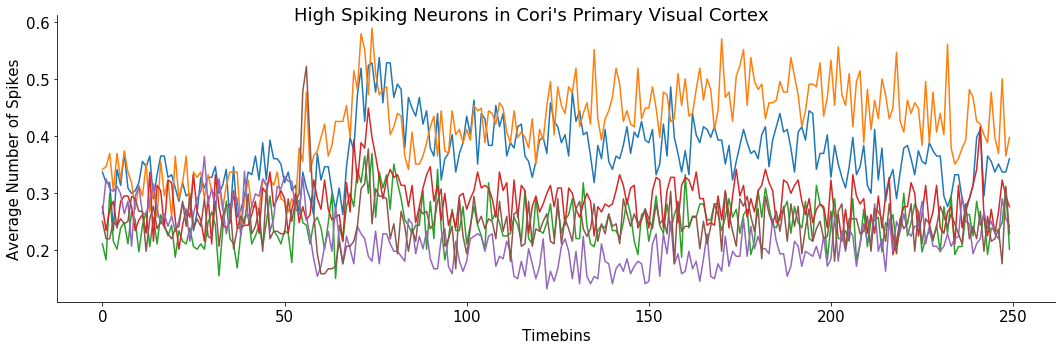

In [23]:
plot_region_spikes_by_mouse(mouse_name='Cori', mouse_dict=mouse_dict, assigned_region='VISp')

Many mice, many regions analysis:

In [24]:
# Create a list of regions that we're interested in 
assigned_regions = ['CA1', 'CA3',"VISp", "VISpm", "VISrl", "VISam", "VISa", "DG", "MD", "MOs", "MG", "MOp" ,]

# All areas:
# "VISp", "VISpm", "VISI", "VISrl", "VISam", "VISa", 'CA1', 'CA3', "DG", "CP", "SCm", "SCs", "SNr", "SSp", 
# "ACA", "ILA", "GPe", "ACB", "APN", "BLA", "LD", "LGd", "LP", "LS", "MD", "MG", "MOp", "MOs", "MRN", "OLF", 
# "ORB", "PAG", "PL", "PO", "POL", "POST", "RSP", "RT", "SUB", "ZI", "VPL", "VPM"

# NOTES:
# !!! the order that the regions are entered into the list matters !!!
# VISI throws an error



In [25]:
def spikes_in_regions_analysis(assigned_regions, mouse_dict):
    """
    For each mice in the steinmetz dataset
    this function plots the average spiking in each region that has been have passed in.
    The lines on each plot represents the mice that had those areas recorded from
    
    Args:
        assigned regions: brain regions that we have decided to look at 
        mouse_dict: the dictionary containing mouse spiking data, keyed by name
            
    Outputs:
        plots by region  
    """
    
    # go through analyses for every region, group the results by mice 
    for assigned_region in assigned_regions:
        all_mice_names = []
        all_mice_lines = None

        for mouse in mouse_dict.keys():
            mouse_data = mouse_dict[mouse] 
            num_sessions = len(mouse_dict[mouse])

            spk_all_sessions = None

            for session in mouse_data:
                spk_session = session['spks']            
                if assigned_region in session['brain_area']:
                    spk_session_region = spk_session[session['brain_area'] == assigned_region]

                    # average over trials
                    spk_session_region_avg = np.mean(spk_session_region, axis=1)

                    if spk_all_sessions is not None:
                        spk_all_sessions = np.concatenate((spk_all_sessions, spk_session_region_avg))
                    else:
                        spk_all_sessions = spk_session_region_avg


            # average over all neurons
            if spk_all_sessions is not None:
                name_i = mouse
                all_mice_names.append(name_i)
                mouse_i = np.mean(spk_all_sessions, axis=0)
                mouse_i = np.expand_dims(mouse_i, 0)

                if all_mice_lines is not None:
                    all_mice_lines = np.concatenate((all_mice_lines, mouse_i), axis = 0)
                else:
                    all_mice_lines = mouse_i 

        plot = plt.figure(figsize=(10, 5))
        plt.plot(all_mice_lines.T) # had to transpose so that time was on the x axis 

        plot.suptitle("Spike Rate in {}".format(assigned_region))
        plt.xlabel("Timebins")  
        plt.ylabel("Average Spikes")
        plt.legend(all_mice_names, loc = "upper right")
        pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots').mkdir(parents=True, exist_ok=True)
        # TODO change file path to consistent naming convention 
        plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/spike_rate_in_{}.png'.format(assigned_region))
        plt.show(plot)


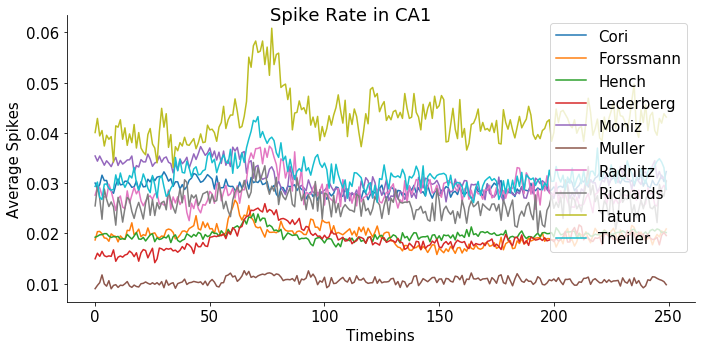

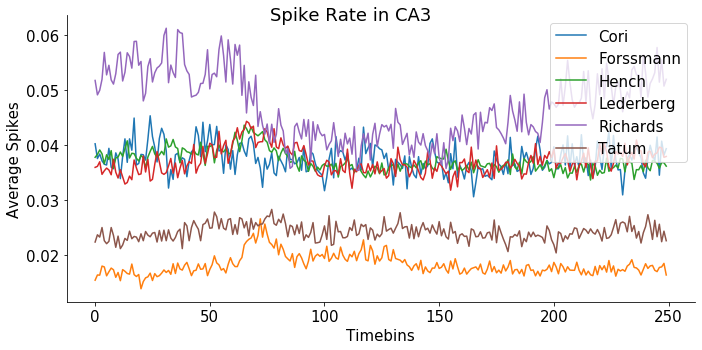

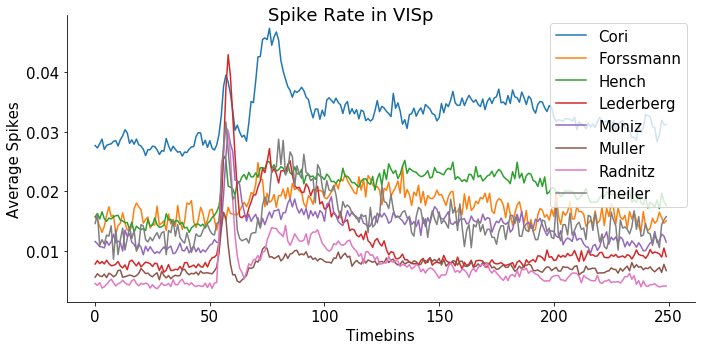

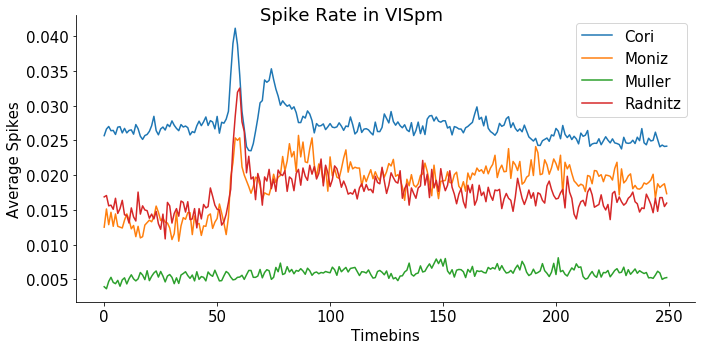

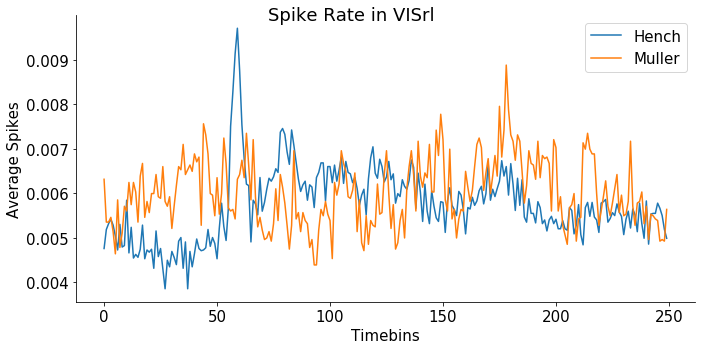

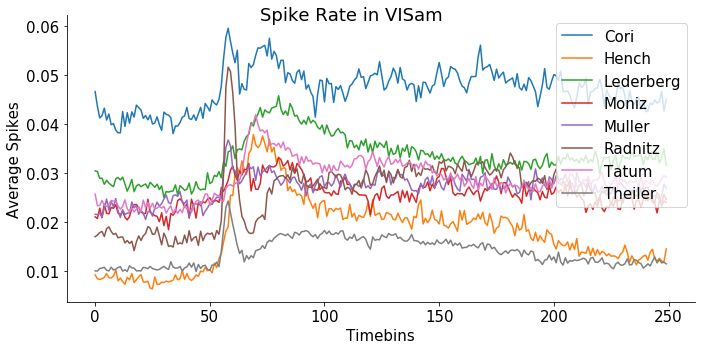

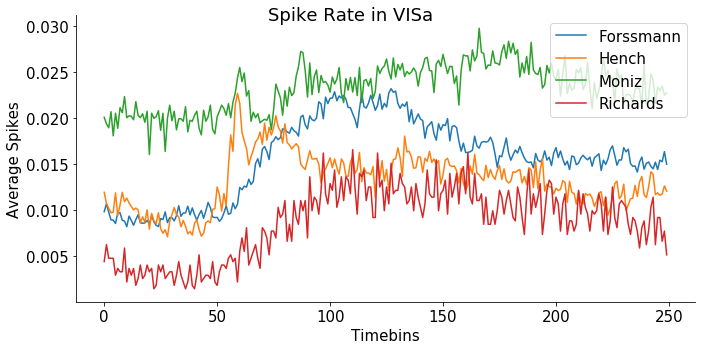

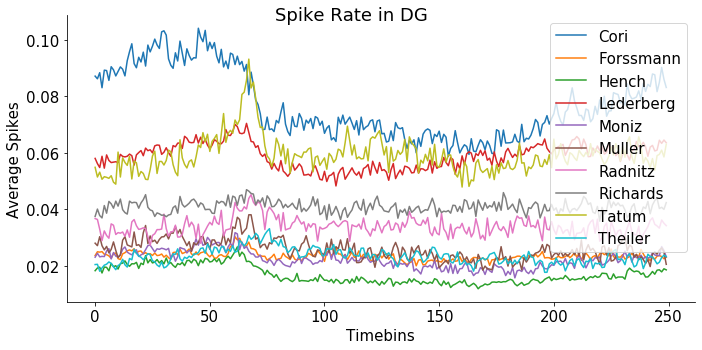

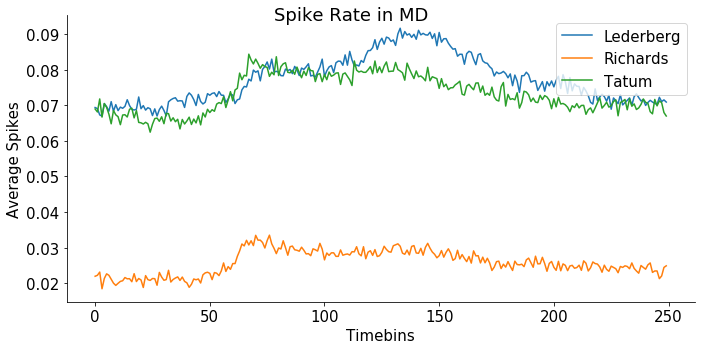

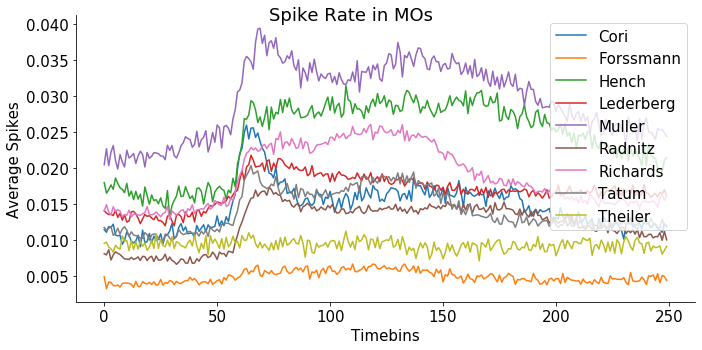

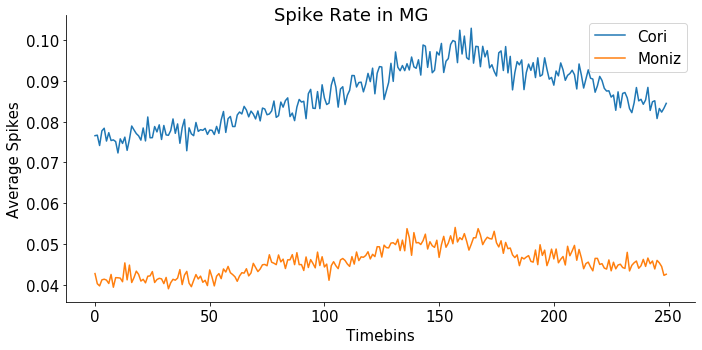

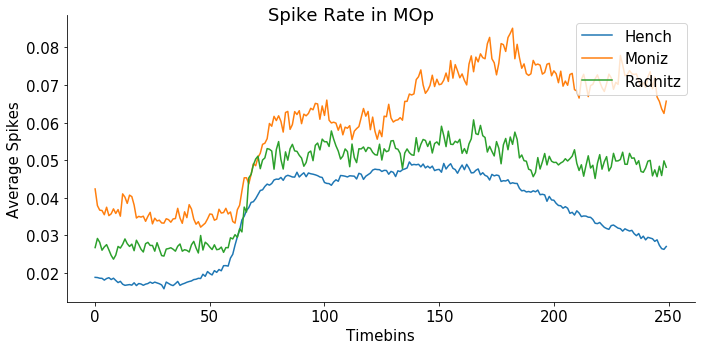

In [26]:
spikes_in_regions_analysis(assigned_regions, mouse_dict)

#### Spiking Analyses based on stimuli and response  👀

In [27]:
# Get some information about the visual stimuli the mice were shown
chosen_session = steinmetz_data[14]
right_visual_stim_type = np.unique(chosen_session['contrast_right'])
left_visual_stim_type = np.unique(chosen_session['contrast_left'])

In [28]:
def visual_stimuli_contrast_test():
    if np.array_equal(right_visual_stim_type, left_visual_stim_type):
        print('The R and L visual stimuli contrast levels are the same')
visual_stimuli_contrast_test()    

The R and L visual stimuli contrast levels are the same


In [29]:
def response_stim_spike_analysis(session, session_num):
    """
    Analyses the neuron spiking frequency for a given visual stimuli and a movement response.
    - Stimuli is either not shown, low contrast(0.25), or high contrast (gaussian blur)
    - Response is either a left(coded as -1) or right(coded at 1) movement, or no movement (0) 
    
    Args:
        session: the indexed steinmetz_data for session of interested in 
        session_num: takes in an int which is the corresponding number value for the session
       
    Outputs:
        A plot!!        
    """

    dt = session['bin_size'] # time is binned by 10ms chunks
    nt = session['spks'].shape[-1]

    # get the movement response and visual stimuli
    response = session['response']
    vis_right = session['contrast_right'] 
    vis_left = session['contrast_left'] 
    avg_gocue = (np.mean(session["gocue"])) # it's more insightful to see if the spikes correlate with a cue 


    plt.plot(dt * np.arange(nt), 1 / dt * session['spks'][:,response >= 0].mean(axis=(0,1))) # left responses
    plt.plot(dt * np.arange(nt), 1 / dt * session['spks'][:,response < 0].mean(axis=(0,1))) # right responses
    plt.plot(dt * np.arange(nt), 1 / dt * session['spks'][:,vis_right > 0].mean(axis=(0,1))) # right stimuli
    plt.plot(dt * np.arange(nt), 1 / dt * session['spks'][:,vis_right == 0].mean(axis=(0,1))) # left stimuli
    plt.axvline(avg_gocue, color = 'black')

    plt.title("Session {} Spike Frequency".format(session_num))
    plt.xlabel("Time (sec)")
    plt.ylabel("Firing rate (Hz)")
    plt.legend(['left resp', 'right resp', 'right stim', 'left stim', 'avg go cue onset'], fontsize = 14)
    pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/FreqPlots').mkdir(parents = True, exist_ok = True)
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/FreqPlots/session_{}_spikes.png'.format(session_num))

    plt.show()

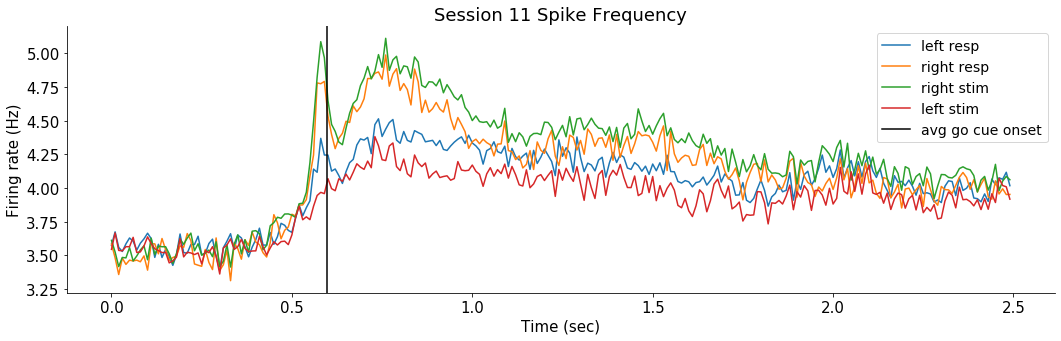

In [30]:
response_stim_spike_analysis(session=steinmetz_data[11], session_num=11) # analyses for Lederberg : session 11

##### Not all spiking is informative spiking:
(for example background music playing may produce high spiking in auditory regions)
let's hone in and focus on the areas that may process task relevant data


In [31]:
session_11 = steinmetz_data[11]

# given that this task was a visuomotor task
# in session 11 there are 4 integration areas recorded from
num_good_areas = 4 
neurons = len(session_11['brain_area']) 
good_areas = num_good_areas * np.ones(neurons, ) # note: last brain region is "other" so it's not relevant

for i in range(num_good_areas):
    good_areas[np.isin(session_11['brain_area'], brain_groups[i])] = i # assign a number to each region

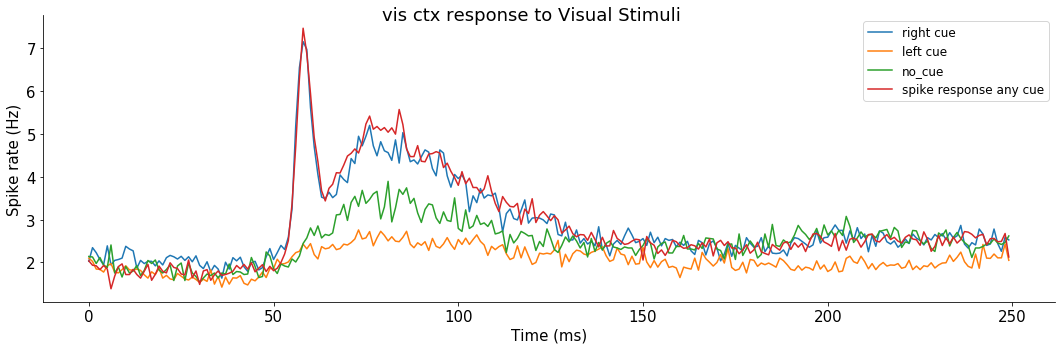

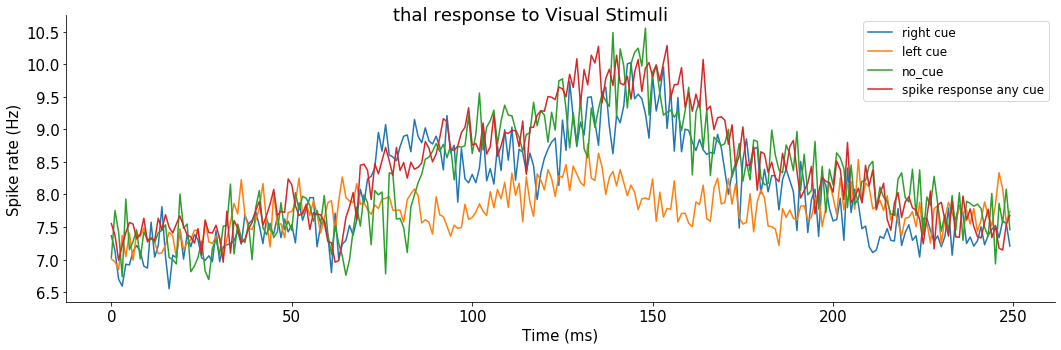

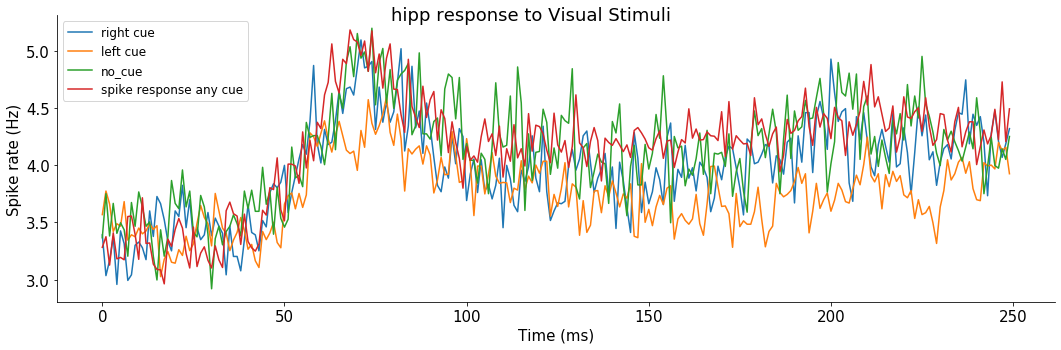

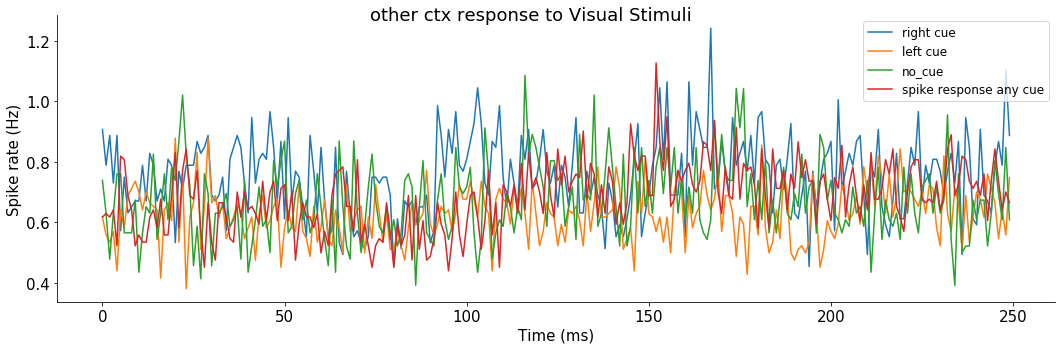

In [32]:
# Plots of the neural response to visual stimuli for the important areas

for i in range(num_good_areas):
    
    # set the time steps to bin size
    dt = session_11['bin_size'] # time is binned by 10ms chunks

    # get the visual stimuli
    vis_right = session_11['contrast_right'] 
    vis_left = session_11['contrast_left']
    
    fig, axs = plt.subplots(sharey = True)
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left == 0, vis_right > 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left == 0, vis_right == 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left > 0, vis_right == 0)].mean(axis=(0,1)))
    plt.plot(1 / dt * session_11['spks'][good_areas == i][:,np.logical_and(vis_left > 0, vis_right > 0)].mean(axis=(0,1)))
    
    fig.suptitle('{} response to Visual Stimuli'.format(regions[i]))
    plt.xlabel('Time (ms)')
    plt.ylabel('Spike rate (Hz)')
    plt.legend(['right cue', 'left cue', 'no_cue', 'spike response any cue'], fontsize=12)
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/ResponseSpikeAnalyses/session11_{}_vep.png'.format(regions[i]))


## Now let's model 🧠

Neural Decoding:
- can we predict movement from neural spiking
- which areas are the best predictors of movement

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D

In [34]:
session_data = steinmetz_data[11]
session_spikes = session_data['spks']
response = session_data['response']
quick_info = session_spikes.shape
print("Number of neurons recorded in all trials: {}, Number of Trials: {}".format(quick_info[0], quick_info[1]))
print('Number of timebins: {}'.format(quick_info[2]))

Number of neurons recorded in all trials: 698, Number of Trials: 340
Number of timebins: 250


In [35]:
def response_predict(session_spikes, response):
    """
    Creates a Logistic Regression model that tries to predict movement
    based on the neuron's spikes. 
    
    Args:
        session spikes(3D array): the spiking data for a given session
        response: the movement responses for a defined session (left coded as 1, right coded as -1, no-go coded as 0)
 
    Output:
        A prediction score based on all of the brain activity that was captured during the session
    """
    
    session_spikes_avg_over_time = np.mean(session_spikes, axis=2) # need to flatten the data so avgd over timebins
    Y = (response != 0).astype(int) 
    model = LogisticRegression()
    model_fit = model.fit(session_spikes_avg_over_time.T,Y)
    return model_fit.score(session_spikes_avg_over_time.T,Y)

brain_movement_prediction = response_predict(session_spikes, session_data['response'])
brain_movement_prediction

0.9205882352941176

In [36]:
def global_brain_prediction_test(brain_movement_prediction):
    assert brain_movement_prediction > 0.9, "global brain prediction returned below 0.9"

In [37]:
global_brain_prediction_test(brain_movement_prediction)

In [38]:
def response_predict_by_area(session_data_area, session_data_response):
    """
    Creates a Logistic Regression model that uses the spiking data in each brain area that was recorded from in 
    the session to predict movement. 
    
    Args:
        session spikes(3D array): the spiking data for a given session
        response(1D array): the movement responses for a defined session (left coded as 1, right coded as -1, no-go coded as 0)
        session_data_area: the brain areas recorded from within the session
 
    Output:
        A prediction score based on all of the brain activity that was captured during the session
    """
    regions = np.unique(session_data_area)
    spikes_in_a_region = {}
    area_prediction_scores = {}
    movement = session_data['response'] 
    Y = (movement != 0).astype(int)

    for region in regions:
        spikes_in_a_region[region] = session_data['spks'][np.where(session_data['brain_area']==region)]
        session_spikes_avg_over_time = np.mean(spikes_in_a_region[region], axis=2)
        model = LogisticRegression()
        model_fit = model.fit(session_spikes_avg_over_time.T,Y)
        accuracy = model_fit.score(session_spikes_avg_over_time.T,Y)
        area_prediction_scores[region] = accuracy
        print("Region: {} {}".format(region, accuracy))
    return spikes_in_a_region

In [39]:
model_prediction_by_area = response_predict_by_area(session_data['brain_area'], session_data['response'])

Region: ACA 0.8117647058823529
Region: CA1 0.8117647058823529
Region: DG 0.8117647058823529
Region: LGd 0.8117647058823529
Region: LH 0.8117647058823529
Region: MD 0.8529411764705882
Region: MOs 0.8117647058823529
Region: PL 0.8117647058823529
Region: SUB 0.8147058823529412
Region: VISam 0.8117647058823529
Region: VISp 0.8117647058823529
Region: root 0.8117647058823529


#### Dimensionality Reduction
Completely averaging over all time isn't a super great thing to do - so let's do a PCA to preserve some of the dimensionality of the time related information. 
- Similar question as the analyses as above, but instead of flattening/collapsing over time, I'm using PCA (allow time to have an influence)

In [40]:
session_data = steinmetz_data[11]

In [41]:
n_neurons = len(session_data['brain_area']) # number of neurons

# creates a 200ms time window where a movement in response to stimuli would occur
data = np.reshape(session_data['spks'][:,:,50:150], (n_neurons,-1))
data = data - np.mean(data, axis=1)[:, np.newaxis]
standardized_data = StandardScaler().fit_transform(data)
pca = PCA(n_components = 5)
principle_components = pca.fit_transform(standardized_data)
principle_components

array([[ -3.2046479 ,  -5.97813463,   1.58519599,   0.51348436,
          0.93981463],
       [ -3.44560062,  -5.50669006,   1.69527517,   0.47414939,
          1.32546137],
       [ 18.9332691 ,  -3.2595786 , -13.7213595 ,   5.44082294,
         10.40534518],
       ...,
       [ -4.71695176,  -5.5538527 ,   1.99154097,   0.17560449,
          0.94101469],
       [ -4.73489274,  -5.56685585,   2.16384625,   0.29636482,
          0.84190674],
       [ 28.5177227 ,  -6.16627936, -61.75949694, -35.27775735,
         51.54860855]])


Principle Component Analysis to reduce the time dimension isn't super informative if we're interested in movement and neuronal spiking within this dataset 

!!! BUT !!!

it IS an incredibly useful tool. So let's use it for some different analyses 

In [44]:
# Let's separate correct and incorrect trials 
# assess if the movement (R, L, or no go) was "correct" based on the stimuli presented
# sort the trials by correctness and the movement response given

is_correct = np.sign(response)==np.sign(vis_left-vis_right)
sorted_trials = np.argsort(-is_correct.astype('float32') + response)
nwrong = np.sum(is_correct)
nt = session_data['spks'].shape[-1]

#### Find the top principle components from the time sections closest to the stimulus onset and movement response

In [45]:
# reshape the data and look at time slice closer to stimuli and movement
feature_data = np.reshape(session_data['spks'][:,:,50:150], (n_neurons, -1))
feature_data = feature_data - np.mean(feature_data, axis = 1)[:, np.newaxis]
stim_resp_model = PCA(n_components = 5).fit(feature_data.T)
brainbits = stim_resp_model.components_ 
time_pca = brainbits @ np.reshape(session_data['spks'], (n_neurons, -1)) # use the @ because we want to multiply the matrices
p_components = np.reshape(time_pca, (5, -1, nt)) # reshape takes the data's shape as an input, and then gives the desired shape back

# reshape takes the data's shape as an input, and then gives the desired shape back

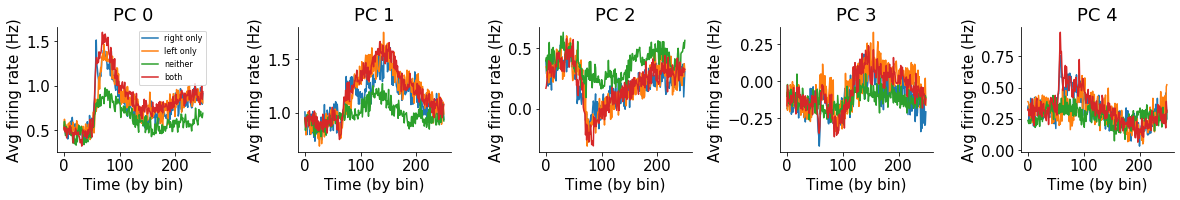

In [46]:
# plot the PC's, and see if there is any (visual) relationship between the visual stimuli presented and avg firing rate

plt.figure(figsize= (20, 5))
for i in range(len(p_components)):
    ax = plt.subplot(2, len(p_components)+1, i+1)
    each_pc = p_components[i]
    
    plt.plot(each_pc[np.logical_and(vis_left == 0, vis_right > 0), :].mean(axis = 0))
    plt.plot(each_pc[np.logical_and(vis_left > 0, vis_right == 0), :].mean(axis = 0))
    plt.plot(each_pc[np.logical_and(vis_left == 0, vis_right == 0), :].mean(axis = 0))
    plt.plot(each_pc[np.logical_and(vis_left > 0, vis_right > 0), :].mean(axis = 0))
    
    if i == 0:
        plt.legend(['right stimuli', 'left stimuli', 'no stimuli', 'any stimuli'], fontsize=8)
    
    ax.set(xlabel = 'Time (by bin)', ylabel = 'Avg firing rate (Hz)')
    plt.title('PC {}'.format(i))
    pathlib.Path('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/PCAPlots').mkdir(parents=True, exist_ok=True)
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/PCAPlots/vstim_pca_plot{}.format.png'.format(i))
           

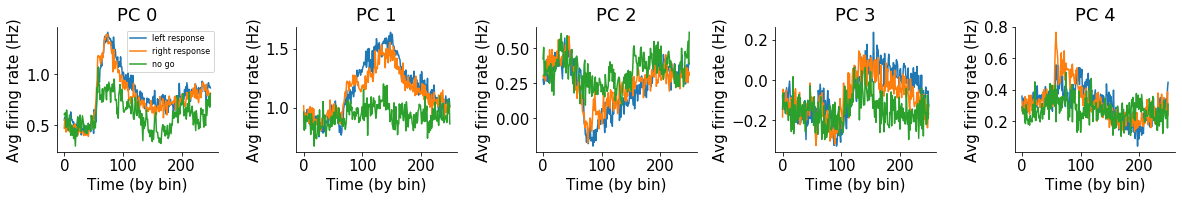

In [47]:
# plot the PC's, and see if there is any (visual) relationship between the visual stimuli presented and avg firing rate

plt.figure(figsize= (20, 5))
for i in range(len(p_components)):
    ax = plt.subplot(2,len(p_components)+1,len(p_components)+1 + i+1)
    each_pc = p_components[i]
  
    plt.plot(each_pc[response>0, :].mean(axis=0))  
    plt.plot(each_pc[response<0, :].mean(axis=0))
    plt.plot(each_pc[response==0, :].mean(axis=0))

    if i == 0:
        plt.legend(['left response', 'right response', 'no go'], fontsize=8)
    ax.set(xlabel = 'Time (by bin)', ylabel = 'Avg firing rate (Hz)')
    plt.title('PC {}'.format(i))
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/response_pca_plot{}.format.png'.format(i))
    

#### Explore the correlation between neuron spiking and the movement response 

In [51]:
def get_corr(average_neuron_activation_in_a_trial, response, mode=None, plot=False):
    """
    Function to find the correlation between neuron activity and a movement response.
    
    Args:
        average_neuron_activation_in_a_trial: gives an avg of a neuron's activity for a trial 
        response(1D array): the movement responses (left coded as 1, right coded as -1, no-go coded as 0)
        mode: the "mode" of data we're interested in ie. if the int is positive, negative, or absolute values
        plot: a boolean to set if a plot should be shown or not
        
        Returns:
            corr_np: the correlation values
    """
    
    # look at movement (is their a neuron that fires differently for left right (answer:not really))
    corr_list = []

    resp = response.copy()
    if mode == "abs":
        resp = np.abs(resp)
        y_title = "correlation to any move"

    elif mode == "neg":
        resp[resp>0]=0
        resp[resp<0]=1
        y_title = "correlation to negative move"

    elif mode == "pos":
        resp[resp<0]=0
        y_title = "correlation to positive move"

    else:
        y_title = "Correlation to Movement and Neuron Spiking Values"
    for i in range(len(resp)):
        corr_list.append(np.correlate(average_neuron_activation_in_a_trial[i], resp))

    corr_np = np.array(corr_list).squeeze()
    if plot:
        plt.scatter(xvals, corr_np)
        plt.title(y_title)
        plt.xlabel("Neuron")
        plt.ylabel("Correlation")
        plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/{}_plot.png'.format(y_title))
        plt.show()
    return corr_np

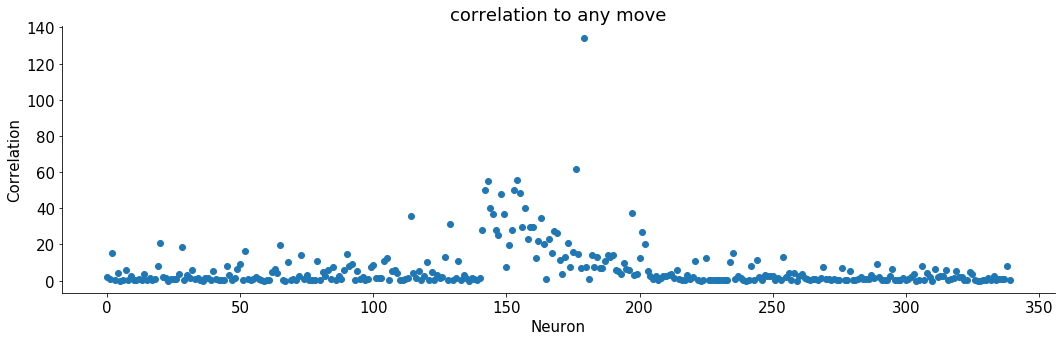

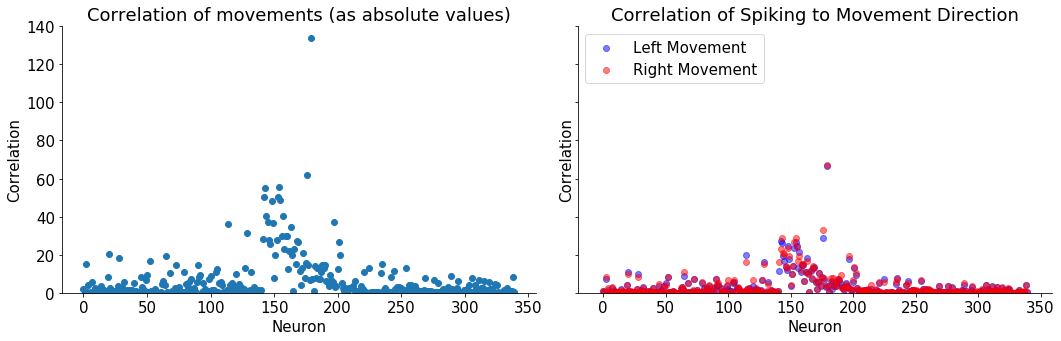

In [52]:
average_neuron_activation_in_a_trial = np.mean(session_spikes, axis=2)
xvals = np.arange(response.shape[0])

corr_np = get_corr(average_neuron_activation_in_a_trial, response, plot=False)
corr_abs_np = get_corr(average_neuron_activation_in_a_trial, response, mode="abs", plot=True)
corr_neg_np = get_corr(average_neuron_activation_in_a_trial, response, mode="neg", plot=False)
corr_pos_np = get_corr(average_neuron_activation_in_a_trial, response, mode="pos", plot=False)

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.scatter(xvals, corr_abs_np)
ax1.title.set_text("Correlation of movements (as absolute values)")
ax1.set_xlabel("Neuron")
ax1.set_ylabel("Correlation")
ax1.set_ylim([0, 140])

ax2.scatter(xvals, corr_pos_np, c="b", alpha=0.5, label="Left Movement")
ax2.scatter(xvals, corr_neg_np, c="r", alpha=0.5, label="Right Movement")
ax2.title.set_text("Correlation of Spiking to Movement Direction")
ax2.legend(loc="upper left")
ax2.set_xlabel("Neuron")
ax2.set_ylabel("Correlation")

plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/movement_direction_correlation_plots.png')
plt.show()



In [73]:
# Find the neurons that have the best and worst correlations to movement.

performance_neurons = 5

# sorted generates from bad to good
top_neurons = sorted(range(len(corr_abs_np)), key=lambda i: corr_abs_np[i])[::-1] # reverse the order
worst_neurons = sorted(range(len(corr_abs_np)), key=lambda i: corr_abs_np[i])
neuro_performers = pd.DataFrame(np.array([top_neurons[:performance_neurons],worst_neurons[:performance_neurons]]), index = ['Top Neurons', 'Worst Neurons'])
neuro_performers

0    1    2    3    4
Top Neurons    179  176  154  143  153
Worst Neurons    5  136   67  223   36

In [ ]:
print("correlations of top neurons {}".format(corr_abs_np[top_neurons][:performance_neurons])

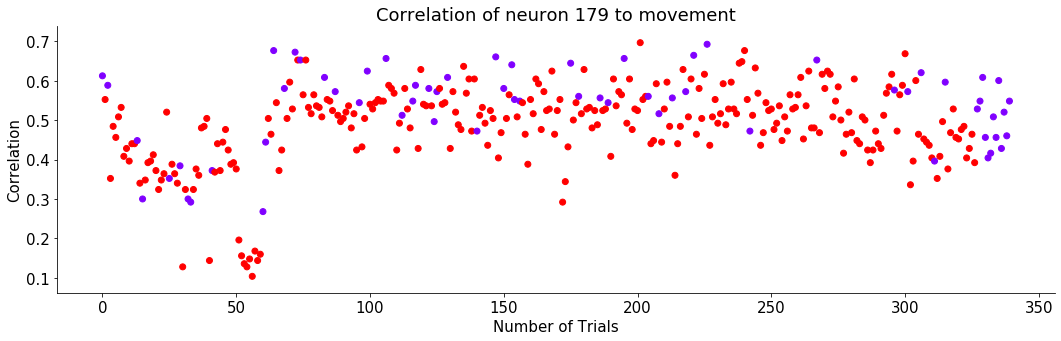

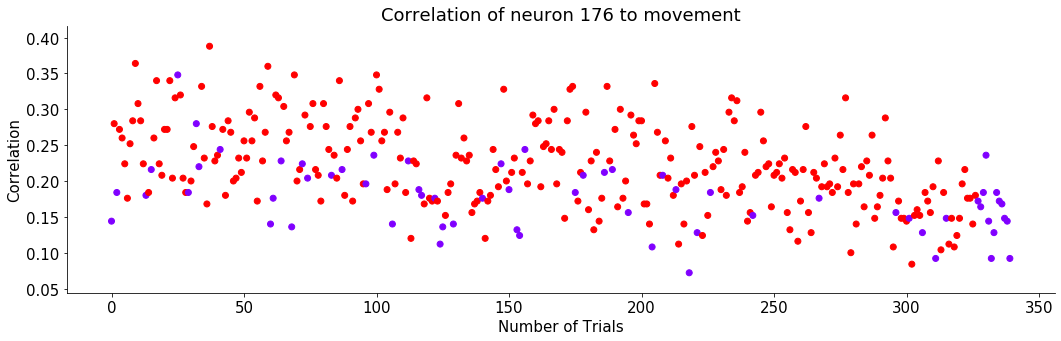

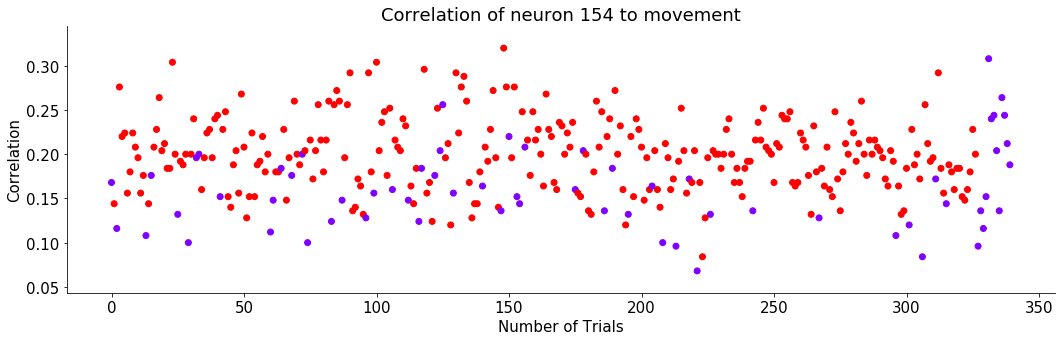

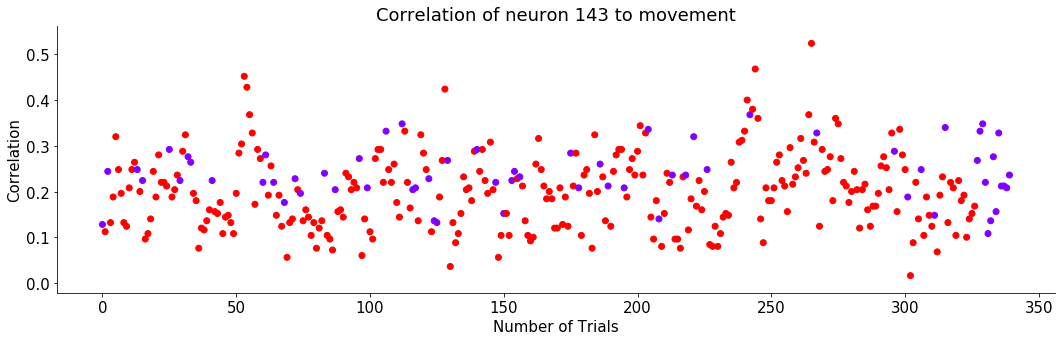

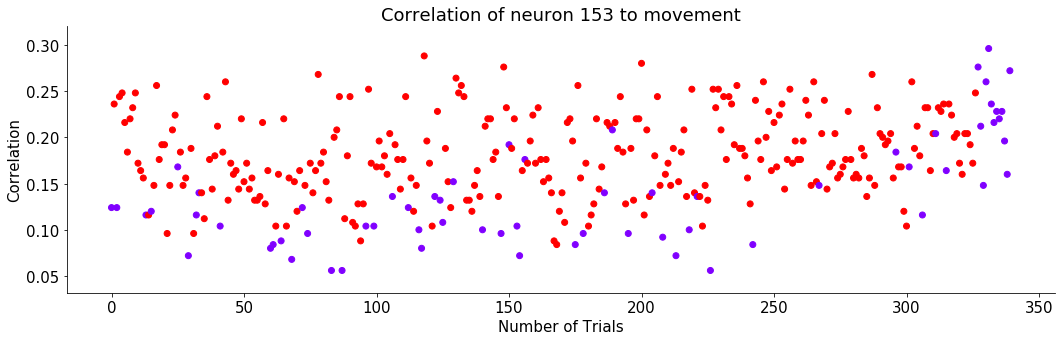

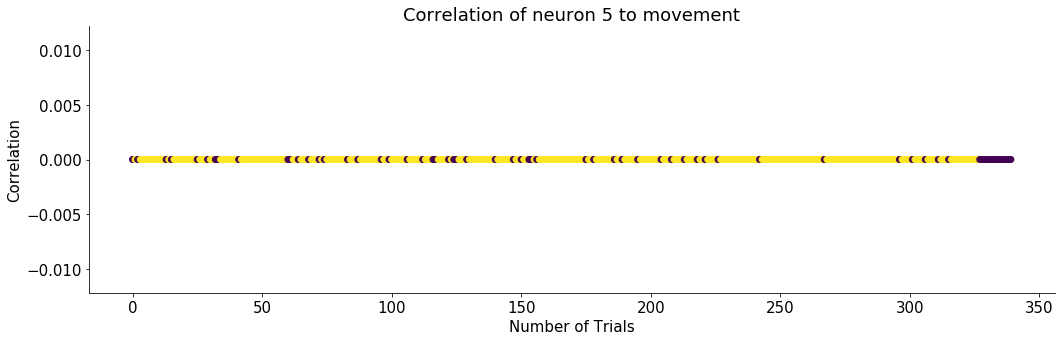

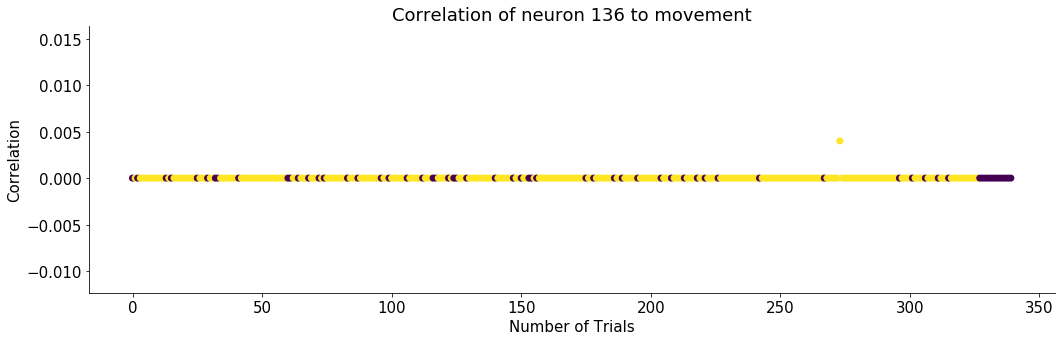

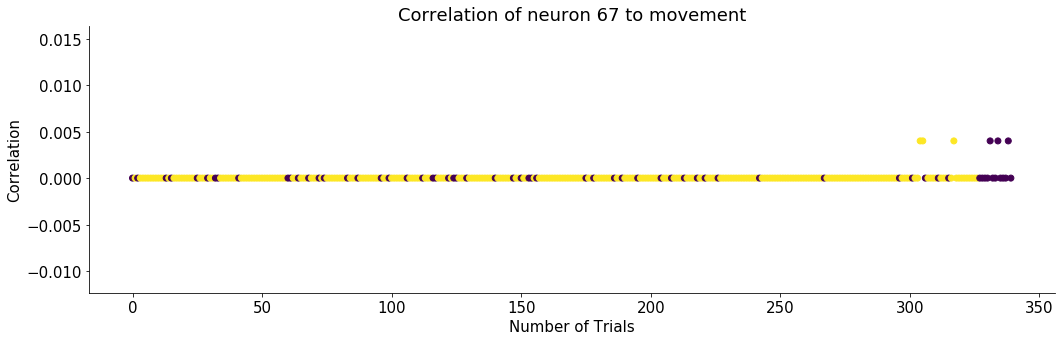

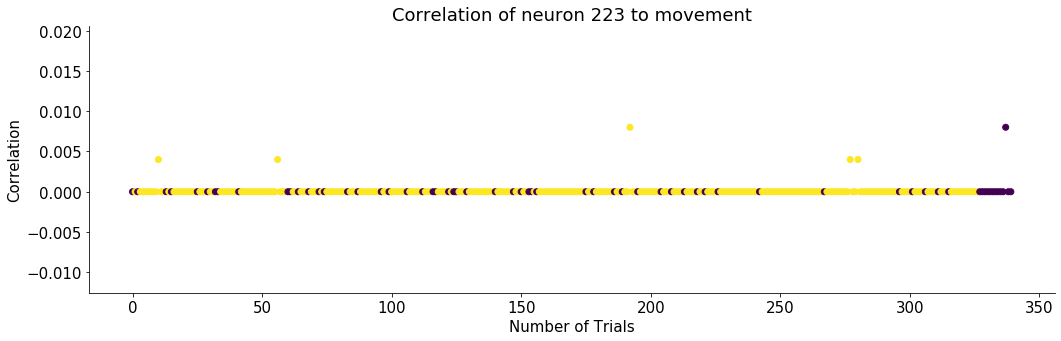

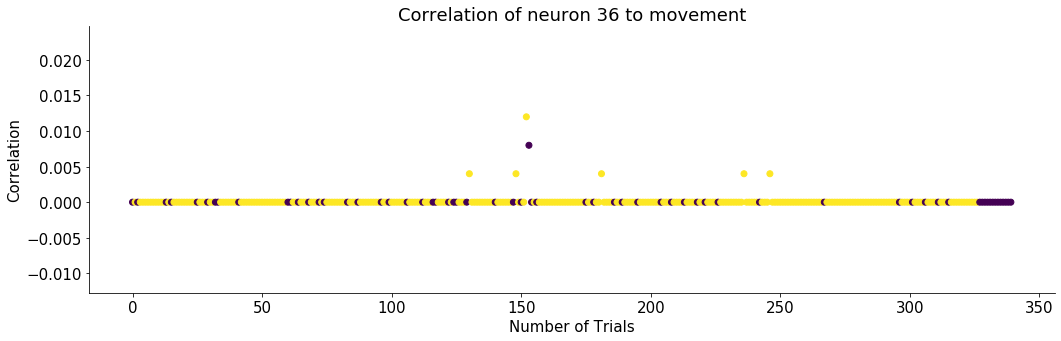

In [74]:
# activation of neurons across all trials 
# - colour based on the movement response value (0 or 1)
# - they are closely clustered meaning that 179 is not good enough to fully preduct movement 


for neurons in top_neurons[:performance_neurons]:
    plt.scatter(np.arange(len(average_neuron_activation_in_a_trial[neurons])), average_neuron_activation_in_a_trial[neurons], c=np.abs(response), cmap='rainbow')
    plt.title('Correlation of neuron {} to movement'.format(neurons))
    plt.xlabel('Number of Trials')
    plt.ylabel('Correlation')
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/{}_movement_correlation_plot.png'.format(neurons))
    plt.show()

for neurons in worst_neurons[:performance_neurons]:
    plt.scatter(np.arange(len(average_neuron_activation_in_a_trial[neurons])), average_neuron_activation_in_a_trial[neurons], c=np.abs(response))
    plt.title('Correlation of neuron {} to movement'.format(neurons))
    plt.xlabel('Number of Trials')
    plt.ylabel('Correlation')
    plt.savefig('/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/Plots/{}_movement_correlation_plot.png'.format(neurons))
    plt.show()


pca (340, 3)


/opt/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


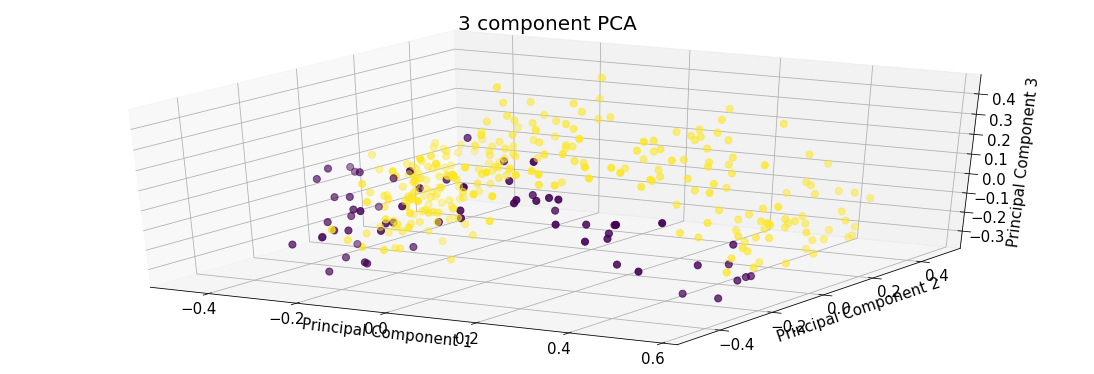

In [54]:
# Each dot is a session
# the location is determined by the averaging spiking over time
# The colour is based on the movemnt (move or not move)


pca = PCA(n_components=3)
pcad = pca.fit_transform(average_neuron_activation_in_a_trial.T)
print("pca", pcad.shape)

principalDf = pd.DataFrame(data=pcad, columns=['pc 1', 'pc 2', 'pc 3'])
 
fig = plt.figure()
ax = Axes3D(fig)

ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_zlabel('Principal Component 3', fontsize = 15)
ax.set_title('3 component PCA', fontsize = 20)

ax.scatter(principalDf.loc[:, 'pc 1']
            , principalDf.loc[:, 'pc 2']
            , principalDf.loc[:, 'pc 3']
            , c = np.abs(response)
            , s = 50)

ax.grid()
plt.show()

# THANK YOU FOR YOUR TIME!! 

I hope you enjoyed seeing some mouse brain data and the awesome tools we can use to understand how the "top two inches" work! 

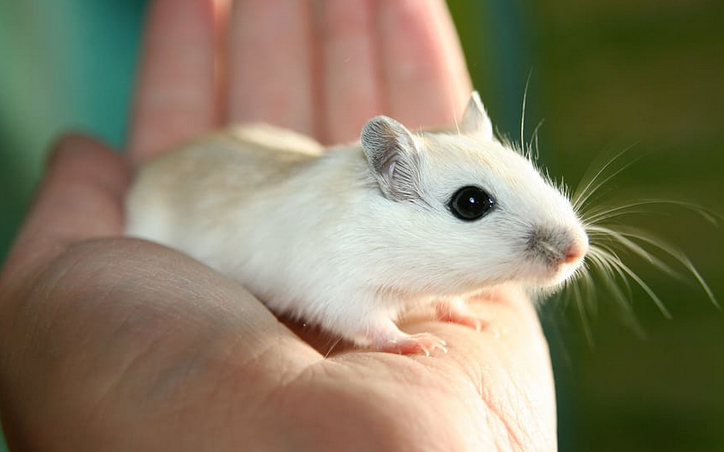

In [80]:
Image(filename = "/Users/sophiabatchelor/Code/SteinmetzAnalyses/Images/mouse.png", width = 600, height = 300)

#### Sophia's Information:
    ssmbatchelor@gmail.com
    @brainonsilicon